In [20]:
import subprocess as sp
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns  # for aesthetic

import neuraltda.topology2 as tp2
import neuraltda.spectralAnalysis as sa
import neuraltda.simpComp as sc
import numpy as np
import tempfile
import h5py as h5
import glob
import os
from importlib import reload
import tqdm
%matplotlib inline

sns.set_style('ticks')

In [90]:
winsize = 10.0
segment_info = [0, 0]
pover = 0.5
block_path = '/home/brad/krista/B1083/P03S03/'
block_path = '/home/brad/krista/B1235/P02S01/'
# Bin data
bfdict = tp2.dag_bin(block_path, winsize, segment_info, cluster_group=['Good', 'MUA'], dt_overlap=pover*winsize, comment='fulltrial')
bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
print(bdf)

Data Not already binned
/home/brad/krista/B1235/P02S01/binned_data/win-10.0_dtovr-5.0_seg-0-0-fulltrial/20170807T212635Z-10.0-5.0.binned


In [91]:
thresh = 13.0
nsamples = 30

nperms=0
ncellsperm=0
dims = [0,1,2,3]
twin = np.linspace(0, 6000, 100)
windt = winsize
dtovr=pover*windt

stim_dict = {}
stim_shuffled_dict = {}
stim_scm_dict = {}
stim_betticurve_dict = {}
stim_shuffled_betticurve_dict = {}

# compute real and shuffled betti curves
(bc, t, tms) = tp2.compute_betti_curves('ForSCMControl', block_path, bdf, thresh, nperms, ncellsperm, dims, twin, windt, dtovr)
(bc_shuff, t, tms) = tp2.compute_betti_curves('ForSCMControl-Shuffle', block_path, bdf, thresh, nperms, ncellsperm, dims, twin, windt, dtovr, shuffle=True)

In [92]:
reload(tp2)
# compute real and shuffled betti curves - TrialAverage
print('Computing trial average')
(bc_tavg, t, tms) = tp2.compute_trialaverage_betti_curves('ForSCMControl', block_path, bdf, thresh, nperms, ncellsperm, dims, twin, windt, dtovr)
(bc_tavg_shuff, t, tms) = tp2.compute_trialaverage_betti_curves('ForSCMControl-Shuffle', block_path, bdf, thresh, nperms, ncellsperm, dims, twin, windt, dtovr, shuffle=True)

Computing trial average


In [12]:
bc['I_40k'].shape

(4, 100, 20)

In [27]:
reload(tp2)
with h5.File(bdf, 'r') as bdff:
    stims = bdff.keys()
    for stim in stims:
        print(stim)
        stim_poptens = tp2.extract_population_tensor(bdf, stim)
        ntrials = tp2.num_trials(stim_poptens)
        stim_scm_dat= []
        for trial in tqdm.tqdm(range(ntrials)):
            scm_bettis = tp2.calc_scm_betti_distribution(stim_poptens, thresh, trial, nsamples)
        
            stim_scm_dat.append(scm_bettis)
        stim_scm_dict[stim] = stim_scm_dat


  0%|          | 0/20 [00:00<?, ?it/s]

0it [00:00, ?it/s]

I_40k
Extracting Population Activity Tensor...
Stim: I_40k, Clusters:None




1it [05:16, 316.98s/it]

3it [05:17, 221.92s/it]

5it [05:17, 155.37s/it]

7it [05:17, 108.79s/it]

9it [05:17, 76.18s/it] 

11it [05:17, 53.35s/it]

13it [05:18, 37.37s/it]

14it [05:18, 26.19s/it]

15it [05:18, 18.36s/it]

17it [05:18, 12.88s/it]

19it [05:18,  9.04s/it]

21it [05:18,  6.36s/it]

23it [05:18,  4.48s/it]

25it [05:19,  3.16s/it]

27it [05:19,  2.24s/it]

29it [05:19,  1.60s/it]

30it [05:19, 10.66s/it]
  5%|▌         | 1/20 [05:19<1:41:13, 319.68s/it]

0it [00:00, ?it/s]


KeyboardInterrupt: 

In [46]:
def plot_scm_distribution(scm_bettis, trial, bettinum, ax=None, **kwargs):
    
    scm_trial_bettis = scm_bettis[trial]
    bettivals = []
    try:
        for x in scm_trial_bettis:
            try:
                bettivals.append(x[0][bettinum])
            except IndexError:
                bettivals.append(0)
    except IndexError:
        bettivals = [x[bettinum] for x in scm_trial_bettis]
    ax.hist(bettivals, 20, normed=1, **kwargs)

In [94]:
# average over all trials
import tqdm
thresh = 13.0
nsamples = 200
stim_dict = {}
stim_shuffled_dict = {}
stim_scm_dict = {}
stim_betticurve_dict = {}
stim_shuffled_betticurve_dict = {}
with h5.File(bdf, 'r') as bdff:
    stims = bdff.keys()
    for stim in tqdm.tqdm(stims):
        print(stim)
        trial=0
        stim_poptens = tp2.extract_population_tensor(bdf, stim)
        ntrials = tp2.num_trials(stim_poptens)
        stim_scm_dat= []
        stim_trialavg_poptens = np.mean(stim_poptens, axis=2)[:, :, np.newaxis]     
        scm_bettis = tp2.calc_scm_betti_distribution(stim_trialavg_poptens, thresh, trial, nsamples)
        stim_scm_dict[stim] = scm_bettis




  0%|          | 0/16 [00:00<?, ?it/s]


0it [00:00, ?it/s]

A_scaled_burung
Extracting Population Activity Tensor...
Stim: A_scaled_burung, Clusters:None





1it [00:58, 58.32s/it]

9it [00:58, 40.82s/it]

17it [00:58, 28.58s/it]

25it [00:58, 20.01s/it]

31it [00:58, 14.01s/it]

39it [00:58,  9.81s/it]

47it [00:58,  6.87s/it]

55it [00:59,  4.82s/it]

63it [00:59,  3.37s/it]

70it [00:59,  2.37s/it]

78it [00:59,  1.66s/it]

86it [00:59,  1.17s/it]

94it [00:59,  1.22it/s]

102it [00:59,  1.73it/s]

110it [00:59,  2.45it/s]

118it [00:59,  3.45it/s]

126it [01:00,  4.83it/s]

134it [01:00,  6.73it/s]

142it [01:00,  9.27it/s]

150it [01:00, 12.60it/s]

159it [01:00, 16.86it/s]

167it [01:00, 21.98it/s]

175it [01:00, 27.93it/s]

183it [01:00, 34.48it/s]

191it [01:00, 41.42it/s]

199it [01:00, 47.86it/s]

200it [01:00,  3.28it/s]
  6%|▋         | 1/16 [01:00<15:14, 60.98s/it]

0it [00:00, ?it/s]

B_scaled_burung
Extracting Population Activity Tensor...
Stim: B_scaled_burung, Clusters:None




1it [00:53, 53.08s/it]

8it [00:53, 37.16s/it]

15it [00:53, 26.01s/it]

22it [00:53, 18.21s/it]

29it [00:53, 12.75s/it]

37it [00:53,  8.93s/it]

44it [00:53,  6.26s/it]

51it [00:53,  4.38s/it]

59it [00:53,  3.07s/it]

66it [00:54,  2.16s/it]

73it [00:54,  1.51s/it]

80it [00:54,  1.06s/it]

87it [00:54,  1.33it/s]

94it [00:54,  1.89it/s]

101it [00:54,  2.67it/s]

108it [00:54,  3.74it/s]

115it [00:54,  5.22it/s]

122it [00:54,  7.20it/s]

129it [00:55,  9.81it/s]

136it [00:55, 13.21it/s]

143it [00:55, 17.42it/s]

150it [00:55, 22.42it/s]

157it [00:55, 27.96it/s]

164it [00:55, 33.61it/s]

171it [00:55, 38.14it/s]

178it [00:55, 43.21it/s]

185it [00:55, 47.84it/s]

192it [00:55, 52.08it/s]

199it [00:56, 55.00it/s]

200it [00:56,  3.56it/s]
 12%|█▎        | 2/16 [01:57<13:53, 59.53s/it]

0it [00:00, ?it/s]

C_scaled_burung
Extracting Population Activity Tensor...
Stim: C_scaled_burung, Clusters:None




1it [01:05, 65.71s/it]

8it [01:05, 46.00s/it]

15it [01:05, 32.21s/it]

22it [01:06, 22.55s/it]

29it [01:06, 15.79s/it]

36it [01:06, 11.06s/it]

43it [01:06,  7.74s/it]

50it [01:06,  5.43s/it]

57it [01:06,  3.80s/it]

64it [01:06,  2.67s/it]

71it [01:06,  1.87s/it]

78it [01:06,  1.31s/it]

85it [01:07,  1.08it/s]

92it [01:07,  1.53it/s]

99it [01:07,  2.17it/s]

106it [01:07,  3.05it/s]

113it [01:07,  4.27it/s]

120it [01:07,  5.92it/s]

127it [01:07,  8.07it/s]

134it [01:07, 10.93it/s]

141it [01:07, 14.54it/s]

148it [01:08, 18.91it/s]

155it [01:08, 23.61it/s]

162it [01:08, 29.06it/s]

169it [01:08, 34.69it/s]

176it [01:08, 40.32it/s]

183it [01:08, 44.98it/s]

190it [01:08, 48.83it/s]

197it [01:08, 51.66it/s]

200it [01:08,  2.90it/s]
 19%|█▉        | 3/16 [03:06<13:30, 62.35s/it]

0it [00:00, ?it/s]

D_scaled_burung
Extracting Population Activity Tensor...
Stim: D_scaled_burung, Clusters:None




1it [01:23, 83.31s/it]

7it [01:23, 58.32s/it]

13it [01:23, 40.83s/it]

19it [01:23, 28.59s/it]

25it [01:23, 20.02s/it]

30it [01:23, 14.02s/it]

36it [01:23,  9.82s/it]

41it [01:24,  6.88s/it]

46it [01:24,  4.82s/it]

51it [01:24,  3.39s/it]

57it [01:24,  2.38s/it]

62it [01:24,  1.67s/it]

68it [01:24,  1.18s/it]

74it [01:24,  1.21it/s]

80it [01:25,  1.71it/s]

86it [01:25,  2.40it/s]

92it [01:25,  3.36it/s]

98it [01:25,  4.68it/s]

104it [01:25,  6.44it/s]

110it [01:25,  8.74it/s]

116it [01:25, 11.61it/s]

122it [01:25, 15.11it/s]

128it [01:25, 19.23it/s]

134it [01:26, 23.84it/s]

140it [01:26, 28.67it/s]

146it [01:26, 33.22it/s]

152it [01:26, 37.53it/s]

158it [01:26, 41.16it/s]

164it [01:26, 44.25it/s]

170it [01:26, 46.07it/s]

176it [01:26, 48.12it/s]

182it [01:26, 50.02it/s]

188it [01:27, 50.85it/s]

194it [01:27, 51.01it/s]

200it [01:27, 50.50it/s]


 25%|██▌       | 4/16 [04:33<13:58, 69.85s/it]

0it [00:00, ?it/s]

E_scaled_burung
Extracting Population Activity Tensor...
Stim: E_scaled_burung, Clusters:None




1it [01:33, 93.24s/it]

8it [01:33, 65.27s/it]

15it [01:33, 45.70s/it]

22it [01:33, 31.99s/it]

29it [01:33, 22.40s/it]

36it [01:33, 15.68s/it]

43it [01:33, 10.98s/it]

50it [01:33,  7.69s/it]

57it [01:34,  5.39s/it]

64it [01:34,  3.78s/it]

71it [01:34,  2.65s/it]

78it [01:34,  1.86s/it]

85it [01:34,  1.31s/it]

92it [01:34,  1.09it/s]

99it [01:34,  1.54it/s]

106it [01:34,  2.18it/s]

113it [01:34,  3.07it/s]

121it [01:35,  4.31it/s]

128it [01:35,  5.98it/s]

135it [01:35,  8.23it/s]

142it [01:35, 11.19it/s]

149it [01:35, 14.92it/s]

156it [01:35, 19.45it/s]

164it [01:35, 24.73it/s]

171it [01:35, 30.24it/s]

178it [01:35, 36.31it/s]

185it [01:36, 41.94it/s]

193it [01:36, 47.69it/s]

200it [01:36, 52.68it/s]


 31%|███▏      | 5/16 [06:09<14:15, 77.78s/it]

0it [00:00, ?it/s]

F_scaled_burung
Extracting Population Activity Tensor...
Stim: F_scaled_burung, Clusters:None




1it [02:04, 124.94s/it]

7it [02:05, 87.46s/it] 

12it [02:05, 61.23s/it]

19it [02:05, 42.86s/it]

26it [02:05, 30.01s/it]

32it [02:05, 21.01s/it]

38it [02:05, 14.71s/it]

45it [02:05, 10.30s/it]

52it [02:05,  7.22s/it]

59it [02:05,  5.06s/it]

66it [02:06,  3.55s/it]

73it [02:06,  2.49s/it]

80it [02:06,  1.75s/it]

86it [02:06,  1.23s/it]

93it [02:06,  1.16it/s]

99it [02:06,  1.64it/s]

106it [02:06,  2.31it/s]

112it [02:06,  3.24it/s]

118it [02:06,  4.53it/s]

124it [02:07,  6.25it/s]

131it [02:07,  8.55it/s]

138it [02:07, 11.55it/s]

144it [02:07, 15.22it/s]

150it [02:07, 19.53it/s]

156it [02:07, 24.39it/s]

163it [02:07, 29.76it/s]

170it [02:07, 35.29it/s]

177it [02:07, 40.30it/s]

184it [02:08, 45.06it/s]

191it [02:08, 48.78it/s]

198it [02:08, 52.36it/s]

200it [02:08,  1.56it/s]
 38%|███▊      | 6/16 [08:17<15:29, 92.94s/it]

0it [00:00, ?it/s]

G_scaled_burung
Extracting Population Activity Tensor...
Stim: G_scaled_burung, Clusters:None




1it [00:41, 41.51s/it]

5it [00:41, 29.07s/it]

9it [00:41, 20.35s/it]

14it [00:41, 14.26s/it]

19it [00:41,  9.99s/it]

23it [00:42,  7.00s/it]

27it [00:42,  4.91s/it]

31it [00:42,  3.44s/it]

35it [00:42,  2.42s/it]

39it [00:42,  1.70s/it]

43it [00:42,  1.20s/it]

48it [00:42,  1.18it/s]

53it [00:42,  1.67it/s]

57it [00:42,  2.34it/s]

62it [00:43,  3.26it/s]

67it [00:43,  4.51it/s]

71it [00:43,  6.13it/s]

76it [00:43,  8.25it/s]

81it [00:43, 10.81it/s]

86it [00:43, 13.73it/s]

91it [00:43, 17.17it/s]

96it [00:43, 20.78it/s]

101it [00:44, 24.42it/s]

106it [00:44, 27.67it/s]

111it [00:44, 30.40it/s]

116it [00:44, 32.10it/s]

120it [00:44, 33.71it/s]

125it [00:44, 35.43it/s]

129it [00:44, 34.85it/s]

133it [00:44, 34.64it/s]

137it [00:45, 35.50it/s]

141it [00:45, 36.12it/s]

145it [00:45, 36.48it/s]

149it [00:45, 36.60it/s]

153it [00:45, 37.41it/s]

157it [00:45, 37.96it/s]

162it [00:45, 38.46it/s]

167it [00:45, 38.84it/s]

171it [00:45, 38.67it/s]

176it [00

H_scaled_burung
Extracting Population Activity Tensor...
Stim: H_scaled_burung, Clusters:None




1it [01:45, 105.40s/it]

3it [01:45, 73.80s/it] 

6it [01:45, 51.67s/it]

9it [01:45, 36.18s/it]

12it [01:45, 25.34s/it]

15it [01:46, 17.75s/it]

18it [01:46, 12.44s/it]

21it [01:46,  8.72s/it]

24it [01:46,  6.12s/it]

27it [01:46,  4.29s/it]

30it [01:46,  3.02s/it]

33it [01:46,  2.12s/it]

36it [01:46,  1.50s/it]

39it [01:47,  1.06s/it]

42it [01:47,  1.33it/s]

45it [01:47,  1.85it/s]

48it [01:47,  2.57it/s]

51it [01:47,  3.52it/s]

54it [01:47,  4.76it/s]

57it [01:47,  6.28it/s]

60it [01:47,  8.08it/s]

63it [01:47, 10.17it/s]

66it [01:48, 12.46it/s]

69it [01:48, 14.70it/s]

72it [01:48, 16.73it/s]

75it [01:48, 18.60it/s]

78it [01:48, 20.35it/s]

81it [01:48, 21.60it/s]

84it [01:48, 22.39it/s]

87it [01:48, 23.53it/s]

90it [01:49, 24.22it/s]

93it [01:49, 24.62it/s]

96it [01:49, 24.59it/s]

99it [01:49, 24.89it/s]

102it [01:49, 25.28it/s]

105it [01:49, 21.67it/s]

108it [01:49, 22.86it/s]

111it [01:49, 23.78it/s]

114it [01:50, 24.52it/s]

117it [01:50, 24.54i

I_scaled_burung
Extracting Population Activity Tensor...
Stim: I_scaled_burung, Clusters:None




1it [01:52, 112.96s/it]

4it [01:53, 79.09s/it] 

7it [01:53, 55.37s/it]

11it [01:53, 38.77s/it]

15it [01:53, 27.15s/it]

19it [01:53, 19.01s/it]

22it [01:53, 13.32s/it]

26it [01:53,  9.33s/it]

30it [01:53,  6.54s/it]

34it [01:54,  4.59s/it]

37it [01:54,  3.22s/it]

40it [01:54,  2.27s/it]

44it [01:54,  1.60s/it]

48it [01:54,  1.13s/it]

52it [01:54,  1.25it/s]

55it [01:54,  1.75it/s]

59it [01:54,  2.44it/s]

62it [01:55,  3.37it/s]

65it [01:55,  4.59it/s]

68it [01:55,  6.13it/s]

72it [01:55,  8.07it/s]

76it [01:55, 10.44it/s]

80it [01:55, 12.93it/s]

84it [01:55, 15.74it/s]

88it [01:55, 18.78it/s]

92it [01:55, 21.39it/s]

96it [01:56, 23.66it/s]

100it [01:56, 25.83it/s]

104it [01:56, 27.56it/s]

108it [01:56, 29.17it/s]

112it [01:56, 30.01it/s]

116it [01:56, 29.54it/s]

120it [01:56, 29.86it/s]

124it [01:57, 28.48it/s]

127it [01:57, 28.70it/s]

131it [01:57, 29.66it/s]

135it [01:57, 30.35it/s]

139it [01:57, 31.26it/s]

143it [01:57, 31.72it/s]

147it [01:57

J_scaled_burung
Extracting Population Activity Tensor...
Stim: J_scaled_burung, Clusters:None




1it [01:13, 73.27s/it]

9it [01:13, 51.29s/it]

17it [01:13, 35.91s/it]

25it [01:13, 25.14s/it]

33it [01:13, 17.60s/it]

42it [01:13, 12.32s/it]

50it [01:13,  8.63s/it]

59it [01:14,  6.05s/it]

67it [01:14,  4.24s/it]

75it [01:14,  2.97s/it]

83it [01:14,  2.08s/it]

91it [01:14,  1.46s/it]

100it [01:14,  1.03s/it]

108it [01:14,  1.38it/s]

116it [01:14,  1.96it/s]

124it [01:14,  2.77it/s]

132it [01:14,  3.88it/s]

140it [01:15,  5.43it/s]

148it [01:15,  7.50it/s]

157it [01:15, 10.30it/s]

166it [01:15, 13.94it/s]

174it [01:15, 18.48it/s]

182it [01:15, 23.92it/s]

190it [01:15, 30.17it/s]

198it [01:15, 36.71it/s]

200it [01:15,  2.64it/s]
 62%|██████▎   | 10/16 [14:13<09:09, 91.66s/it]

0it [00:00, ?it/s]

K_scaled_burung
Extracting Population Activity Tensor...
Stim: K_scaled_burung, Clusters:None




1it [01:06, 66.96s/it]

8it [01:07, 46.88s/it]

16it [01:07, 32.82s/it]

24it [01:07, 22.98s/it]

32it [01:07, 16.09s/it]

40it [01:07, 11.27s/it]

47it [01:07,  7.89s/it]

55it [01:07,  5.53s/it]

63it [01:07,  3.87s/it]

71it [01:07,  2.72s/it]

79it [01:08,  1.90s/it]

87it [01:08,  1.34s/it]

95it [01:08,  1.06it/s]

103it [01:08,  1.51it/s]

111it [01:08,  2.14it/s]

119it [01:08,  3.02it/s]

127it [01:08,  4.24it/s]

135it [01:08,  5.91it/s]

143it [01:08,  8.17it/s]

151it [01:08, 11.17it/s]

159it [01:09, 15.00it/s]

167it [01:09, 19.72it/s]

175it [01:09, 25.31it/s]

183it [01:09, 31.59it/s]

191it [01:09, 38.05it/s]

199it [01:09, 44.34it/s]

200it [01:09,  2.87it/s]
 69%|██████▉   | 11/16 [15:23<07:05, 85.06s/it]

0it [00:00, ?it/s]

L_scaled_burung
Extracting Population Activity Tensor...
Stim: L_scaled_burung, Clusters:None




1it [01:34, 94.21s/it]

8it [01:34, 65.95s/it]

14it [01:34, 46.17s/it]

20it [01:34, 32.33s/it]

26it [01:34, 22.63s/it]

31it [01:34, 15.85s/it]

37it [01:34, 11.10s/it]

43it [01:35,  7.78s/it]

49it [01:35,  5.45s/it]

56it [01:35,  3.82s/it]

62it [01:35,  2.68s/it]

68it [01:35,  1.88s/it]

74it [01:35,  1.32s/it]

81it [01:35,  1.08it/s]

87it [01:35,  1.53it/s]

93it [01:35,  2.15it/s]

100it [01:35,  3.03it/s]

107it [01:36,  4.24it/s]

113it [01:36,  5.88it/s]

120it [01:36,  8.05it/s]

127it [01:36, 10.89it/s]

133it [01:36, 14.40it/s]

140it [01:36, 18.66it/s]

147it [01:36, 23.57it/s]

154it [01:36, 28.78it/s]

161it [01:36, 34.04it/s]

167it [01:37, 38.77it/s]

173it [01:37, 42.94it/s]

179it [01:37, 46.50it/s]

185it [01:37, 49.60it/s]

191it [01:37, 50.71it/s]

197it [01:37, 52.42it/s]

200it [01:37,  2.05it/s]
 75%|███████▌  | 12/16 [17:00<05:55, 88.85s/it]

0it [00:00, ?it/s]

M_scaled_burung
Extracting Population Activity Tensor...
Stim: M_scaled_burung, Clusters:None




1it [01:09, 69.08s/it]

9it [01:09, 48.36s/it]

15it [01:09, 33.86s/it]

23it [01:09, 23.70s/it]

31it [01:09, 16.60s/it]

39it [01:09, 11.62s/it]

47it [01:09,  8.14s/it]

55it [01:09,  5.70s/it]

63it [01:09,  4.00s/it]

71it [01:10,  2.80s/it]

79it [01:10,  1.96s/it]

87it [01:10,  1.38s/it]

95it [01:10,  1.03it/s]

103it [01:10,  1.46it/s]

111it [01:10,  2.07it/s]

119it [01:10,  2.93it/s]

127it [01:10,  4.11it/s]

135it [01:10,  5.73it/s]

143it [01:11,  7.92it/s]

151it [01:11, 10.84it/s]

159it [01:11, 14.49it/s]

167it [01:11, 19.13it/s]

175it [01:11, 24.67it/s]

183it [01:11, 31.04it/s]

191it [01:11, 37.71it/s]

199it [01:11, 44.15it/s]

200it [01:11,  2.79it/s]
 81%|████████▏ | 13/16 [18:12<04:11, 83.74s/it]

0it [00:00, ?it/s]

N_scaled_burung
Extracting Population Activity Tensor...
Stim: N_scaled_burung, Clusters:None




1it [01:54, 114.53s/it]

4it [01:54, 80.18s/it] 

7it [01:54, 56.14s/it]

10it [01:54, 39.31s/it]

13it [01:55, 27.53s/it]

16it [01:55, 19.28s/it]

19it [01:55, 13.51s/it]

22it [01:55,  9.47s/it]

25it [01:55,  6.64s/it]

28it [01:55,  4.66s/it]

31it [01:55,  3.27s/it]

34it [01:55,  2.30s/it]

37it [01:55,  1.62s/it]

40it [01:56,  1.15s/it]

43it [01:56,  1.23it/s]

46it [01:56,  1.72it/s]

49it [01:56,  2.38it/s]

52it [01:56,  3.27it/s]

55it [01:56,  4.43it/s]

58it [01:56,  5.86it/s]

61it [01:56,  7.66it/s]

64it [01:56,  9.83it/s]

67it [01:57, 12.03it/s]

70it [01:57, 14.50it/s]

73it [01:57, 16.41it/s]

76it [01:57, 18.68it/s]

79it [01:57, 20.80it/s]

83it [01:57, 22.87it/s]

86it [01:57, 24.03it/s]

89it [01:57, 24.87it/s]

92it [01:58, 25.19it/s]

95it [01:58, 26.07it/s]

98it [01:58, 26.63it/s]

101it [01:58, 26.96it/s]

104it [01:58, 27.37it/s]

107it [01:58, 28.08it/s]

110it [01:58, 28.56it/s]

113it [01:58, 28.33it/s]

116it [01:58, 28.42it/s]

119it [01:58, 28.3

O_scaled_burung
Extracting Population Activity Tensor...
Stim: O_scaled_burung, Clusters:None




1it [01:00, 60.49s/it]

9it [01:00, 42.35s/it]

17it [01:00, 29.65s/it]

25it [01:00, 20.76s/it]

33it [01:00, 14.53s/it]

42it [01:01, 10.18s/it]

50it [01:01,  7.13s/it]

59it [01:01,  4.99s/it]

67it [01:01,  3.50s/it]

75it [01:01,  2.45s/it]

84it [01:01,  1.72s/it]

92it [01:01,  1.21s/it]

100it [01:01,  1.18it/s]

108it [01:01,  1.67it/s]

116it [01:01,  2.36it/s]

124it [01:02,  3.33it/s]

132it [01:02,  4.66it/s]

140it [01:02,  6.48it/s]

149it [01:02,  8.95it/s]

157it [01:02, 12.14it/s]

165it [01:02, 16.11it/s]

173it [01:02, 20.90it/s]

182it [01:02, 26.85it/s]

190it [01:02, 33.46it/s]

198it [01:03, 40.25it/s]

200it [01:03,  3.17it/s]
 94%|█████████▍| 15/16 [21:17<01:25, 85.62s/it]

0it [00:00, ?it/s]

P_scaled_burung
Extracting Population Activity Tensor...
Stim: P_scaled_burung, Clusters:None




1it [01:35, 95.69s/it]

6it [01:35, 66.99s/it]

11it [01:35, 46.90s/it]

15it [01:36, 32.84s/it]

20it [01:36, 22.99s/it]

24it [01:36, 16.10s/it]

28it [01:36, 11.28s/it]

33it [01:36,  7.90s/it]

37it [01:36,  5.54s/it]

42it [01:36,  3.89s/it]

47it [01:36,  2.73s/it]

52it [01:36,  1.92s/it]

57it [01:37,  1.35s/it]

62it [01:37,  1.05it/s]

67it [01:37,  1.48it/s]

72it [01:37,  2.09it/s]

77it [01:37,  2.92it/s]

82it [01:37,  4.03it/s]

86it [01:37,  5.34it/s]

90it [01:37,  7.21it/s]

94it [01:38,  9.56it/s]

98it [01:38, 12.35it/s]

102it [01:38, 15.57it/s]

106it [01:38, 18.88it/s]

110it [01:38, 22.16it/s]

114it [01:38, 25.56it/s]

118it [01:38, 27.94it/s]

122it [01:38, 30.53it/s]

126it [01:38, 32.09it/s]

130it [01:39, 34.08it/s]

135it [01:39, 35.97it/s]

139it [01:39, 35.77it/s]

143it [01:39, 36.18it/s]

147it [01:39, 36.16it/s]

151it [01:39, 37.15it/s]

155it [01:39, 37.36it/s]

159it [01:39, 36.37it/s]

163it [01:39, 35.87it/s]

167it [01:40, 35.26it/s]

171it [0

In [95]:
import pickle
with open(os.path.join(block_path,'scm_control_save_trialvg.pkl'), 'wb') as f:
    pickle.dump([stim_scm_dict], f)

[  1.  23.   6.   0.]
[  1.  23.   4.   0.]
[  1.  20.  12.   0.]
[  1.  37.   5.   1.]
[  1.  21.  11.   0.]
[  1.  21.  10.   6.]
[  1.  15.   2.   0.]
[  1.  18.  12.   0.]


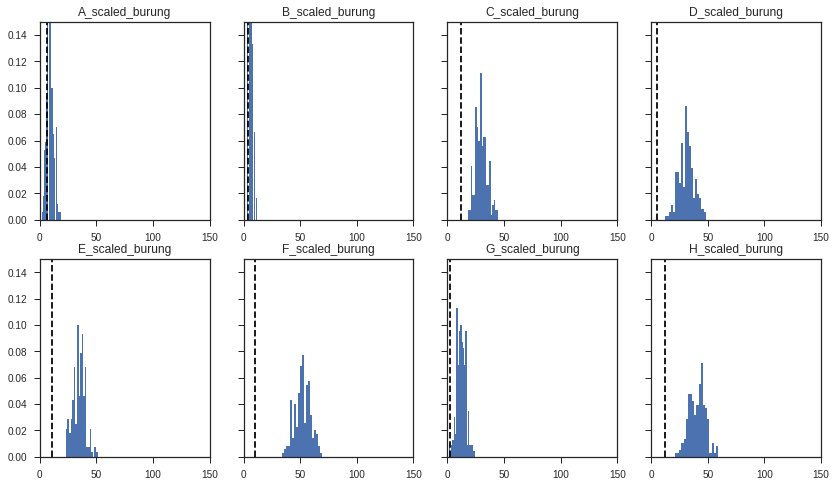

In [98]:
f, axs = plt.subplots(2, 4, sharey=True, figsize=(14, 8))
betti_num =2
for ax, stim in zip(axs.flatten(), bc_tavg.keys()):
    final_bettis = bc_tavg[stim][:, -1, 0]
    #final_bettis = stim_betticurve_dict[stim][-1]
    
    plot_scm_distribution([stim_scm_dict[stim]], 0, betti_num, ax)
    print(final_bettis)
    b = final_bettis[betti_num]
    ax.plot([b, b], [0, 0.15], 'k--')
    ax.set_title(stim)
    ax.set_xlim([0, 150])
    ax.set_ylim([0, 0.15])
    

In [97]:
#compute pvalues
dims2 = [0,1,2]
for stim in bc_tavg.keys():
    for dim in dims2:
        final_betti = bc_tavg[stim][dim, -1, 0]
        scm_dist = np.array(stim_scm_dict[stim])
        scm_dist = [x[0][dim] for x in scm_dist]
        m = np.mean(scm_dist)
        N = len(scm_dist)
        if final_betti > m:
        
            count = np.sum(np.greater(scm_dist, final_betti))
        else:
            count = np.sum(np.less(scm_dist, final_betti))
        p = 2*(1+count)/(N+1)
        print('Stim: {} dim: {}  pvalue: {}'.format(stim, dim, p))
    print('\n')
    

Stim: A_scaled_burung dim: 0  pvalue: 0.009950248756218905
Stim: A_scaled_burung dim: 1  pvalue: 0.029850746268656716
Stim: A_scaled_burung dim: 2  pvalue: 0.23880597014925373


Stim: B_scaled_burung dim: 0  pvalue: 0.009950248756218905
Stim: B_scaled_burung dim: 1  pvalue: 0.009950248756218905
Stim: B_scaled_burung dim: 2  pvalue: 0.5472636815920398


Stim: C_scaled_burung dim: 0  pvalue: 0.009950248756218905
Stim: C_scaled_burung dim: 1  pvalue: 0.15920398009950248
Stim: C_scaled_burung dim: 2  pvalue: 0.009950248756218905


Stim: D_scaled_burung dim: 0  pvalue: 0.009950248756218905
Stim: D_scaled_burung dim: 1  pvalue: 0.009950248756218905
Stim: D_scaled_burung dim: 2  pvalue: 0.009950248756218905


Stim: E_scaled_burung dim: 0  pvalue: 0.009950248756218905
Stim: E_scaled_burung dim: 1  pvalue: 0.10945273631840796
Stim: E_scaled_burung dim: 2  pvalue: 0.009950248756218905


Stim: F_scaled_burung dim: 0  pvalue: 0.009950248756218905
Stim: F_scaled_burung dim: 1  pvalue: 0.00995024875

In [73]:
np.mean(stim_scm_dict[stim][:, :, 1])

IndexError: too many indices for array

In [72]:
stim_scm_dict[stim].shape

(200, 1)

In [86]:
np.array(stim_scm_dict[stim]).shape

(200, 1)

In [82]:
test = stim_scm_dict[stim]


In [85]:
test

array([[array([  2,  62, 185,   0,   0,   0,   0,   0,   0,   0,   0])],
       [array([  2,  59, 155])],
       [array([  2,  52, 201])],
       [array([  2,  69, 136])],
       [array([  2,  53, 153,   0,   0,   0,   0,   0,   0,   0])],
       [array([  2,  57, 184])],
       [array([  2,  55, 174])],
       [array([  2,  51, 157,   1,   0,   0,   0,   0,   0,   0])],
       [array([  2,  63, 170])],
       [array([  2,  66, 178,   0,   0,   0,   0,   0,   0,   0])],
       [array([  2,  58, 147,   1])],
       [array([  2,  59, 164,   0,   0,   0,   0,   0,   0,   0,   0])],
       [array([  2,  59, 164])],
       [array([  2,  61, 150])],
       [array([  2,  51, 180,   0,   0,   0,   0,   0,   0,   0,   0])],
       [array([  2,  51, 170,   0,   0,   0,   0,   0,   0,   0])],
       [array([  2,  60, 188])],
       [array([  2,  54, 154])],
       [array([  2,  47, 194,   0,   0,   0,   0,   0,   0,   0])],
       [array([  2,  62, 159,   1])],
       [array([  2,  60, 165,   1, 